In [2]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
from astropy.io import fits
import math
from astropy import units as u
from astropy.cosmology import Planck15
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pymaster as nmt
import camb
from pathlib import Path
import requests
from scipy.linalg import sqrtm

# Loading the variance map and source map

In [3]:
#Generate a noise map with variance map
Root_dir      = '/shared/data/Assets/Planck/'
Planck_obs_fn = 'HFI_SkyMap_100_2048_R3.01_full.fits'

#Path and fn for Planck's noise maps
Planck_noise_dir = '/home/yunan/planck_release/'

# Example with 100GHz
Planck_noise_fn = {'0': 'ffp10_noise_100_full_map_mc_00000.fits',
                   '1': 'ffp10_noise_100_full_map_mc_00001.fits',
                   '2': 'ffp10_noise_100_full_map_mc_00002.fits',
                   '3': 'ffp10_noise_100_full_map_mc_00003.fits',
                   '4': 'ffp10_noise_100_full_map_mc_00004.fits',
                   '5': 'ffp10_noise_100_full_map_mc_00005.fits'}


In [4]:
#load variance map
planck_obs_path = Root_dir + Planck_obs_fn
Planck_obs_map = hp.read_map(planck_obs_path, hdu = 1,field = (4,7,9))*1e12

#load the noise maps
Planck_noise_map = {}
Planck_noise_map_Q = {}
Planck_noise_map_U = {}
for i in Planck_noise_fn:
    Planck_noise_map[i] = hp.read_map(Planck_noise_dir + Planck_noise_fn[i], field = (0,1,2))*1e6

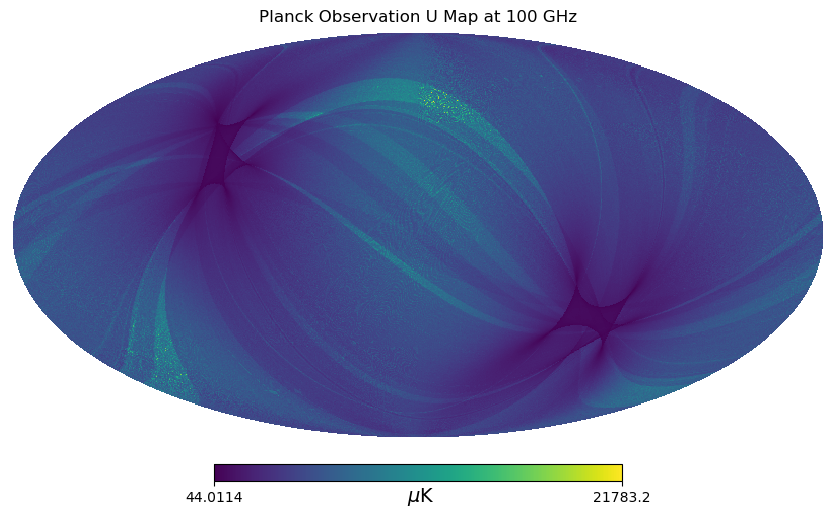

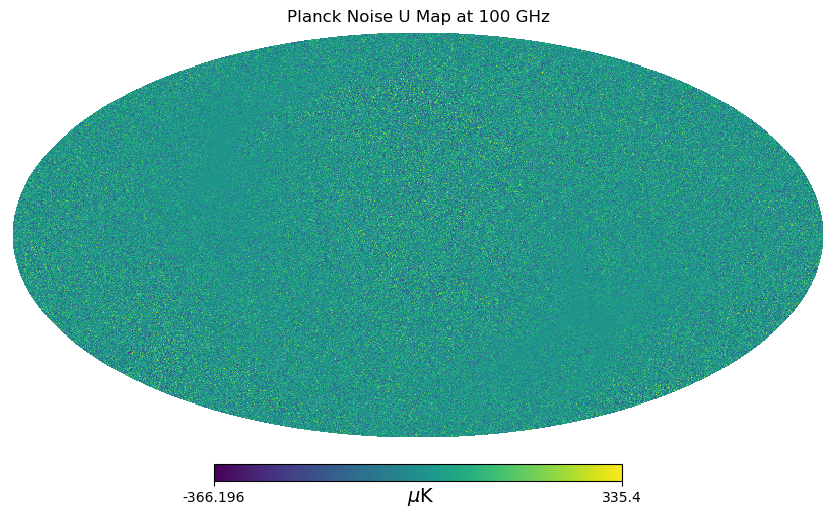

In [5]:
fields = ['I','Q','U']
index = 2
hp.mollview(Planck_obs_map[index], title=f"Planck Observation {fields[index]} Map at 100 GHz", unit=" $\\mu$K")
hp.mollview(Planck_noise_map['0'][index], title=f"Planck Noise {fields[index]} Map at 100 GHz", unit=" $\\mu$K")

In [6]:
# Variance map
Planck_var_map = np.sqrt(np.abs(Planck_obs_map))

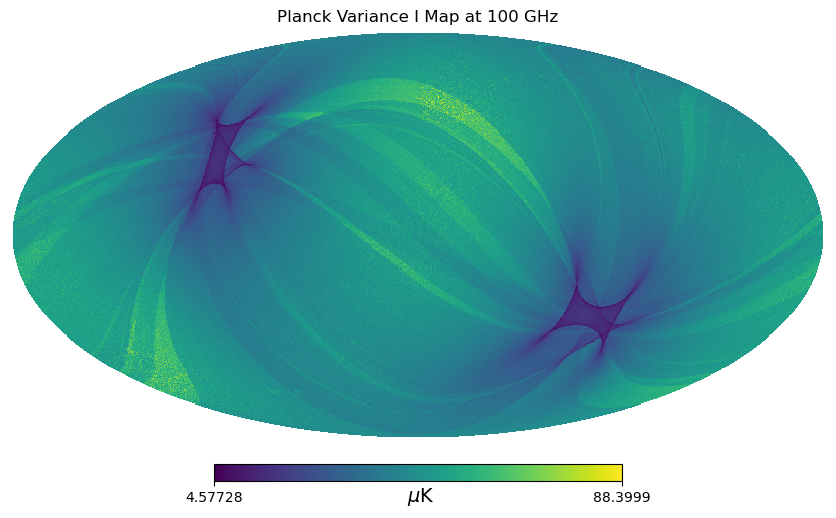

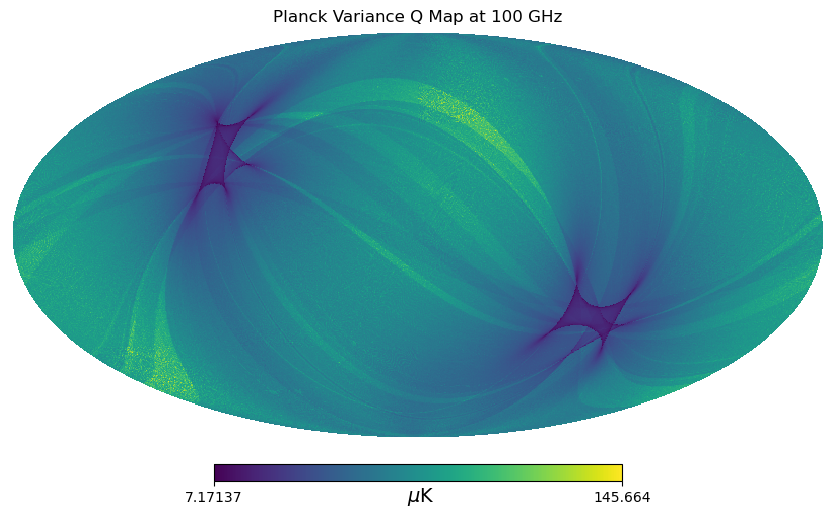

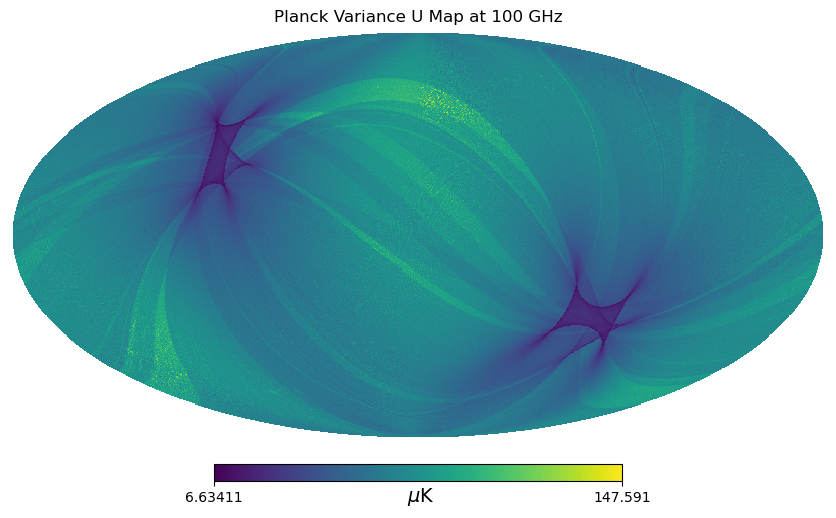

In [7]:
# Visualize the variance map
for i in fields:
    hp.mollview(Planck_var_map[fields.index(i)], title=f"Planck Variance {i} Map at 100 GHz", unit=" $\\mu$K")

In [8]:
# Generate a white noise map from the variance map
rng = np.random.default_rng(1)
white_noise_map_sim = rng.normal(scale = Planck_var_map)

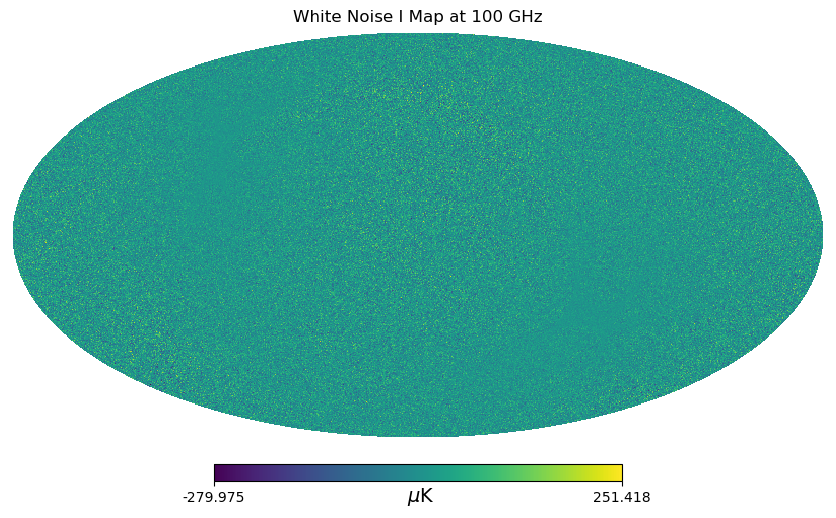

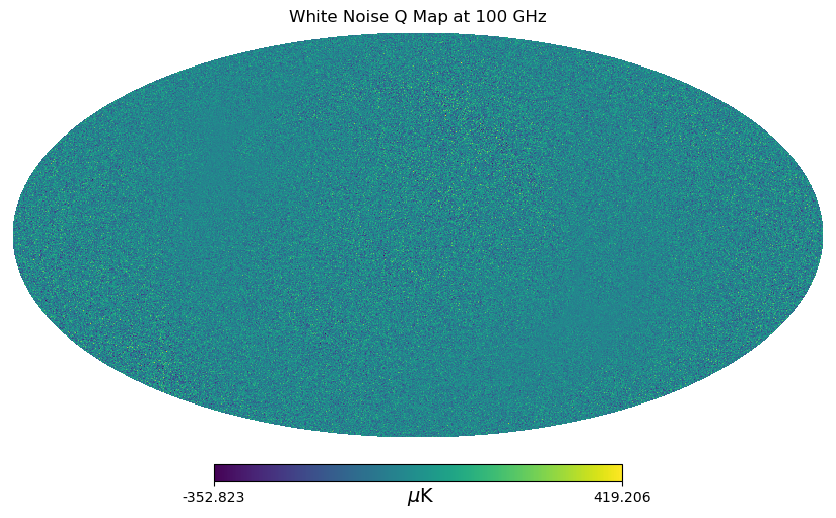

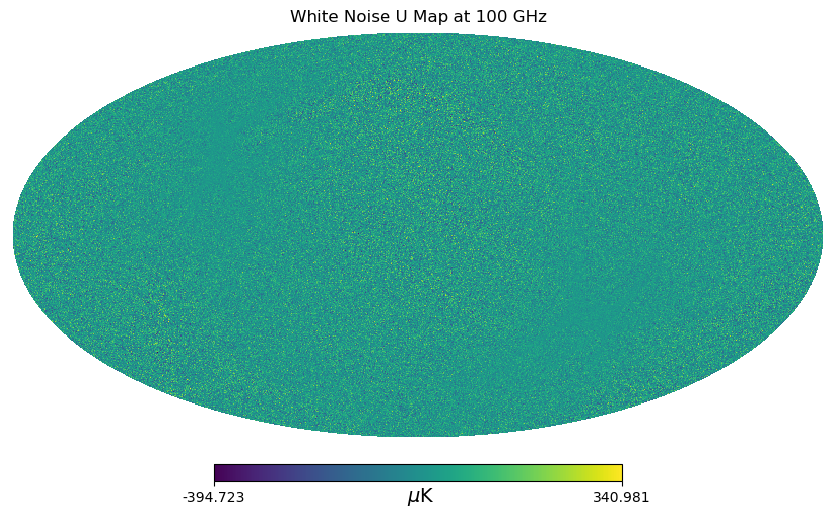

In [9]:
# Visualize the white noise map
for i in fields:
    hp.mollview(white_noise_map_sim[fields.index(i)], title=f"White Noise {i} Map at 100 GHz", unit=" $\\mu$K")

In [10]:
# Convert the white noise map to a harmonic coefficients
nside = 2048
ellmax = 3*nside -1
white_noise_map_sim_alm = hp.map2alm(white_noise_map_sim, lmax=ellmax)

In [11]:
# White nooise map power spectrum
white_noise_map_sim_cl = hp.alm2cl(white_noise_map_sim_alm)

In [12]:
# Construct source covariance matrix
Planck_noise_map_cov = np.zeros((3, 3 , ellmax+1))
Planck_noise_map_cl = hp.anafast(Planck_noise_map['0'], lmax=ellmax)

In [13]:
# Find the filter factor 
filter_factor = np.zeros((3, ellmax+1))
for i in range(3):
    if i == 0:
        filter_factor[i] = Planck_noise_map_cl[i]/ white_noise_map_sim_cl[i]
    filter_factor[i][2:] = Planck_noise_map_cl[i][2:]/ white_noise_map_sim_cl[i][2:]

In [14]:
filter_factor

array([[918.4280007 , 183.74376276,  65.4413274 , ...,   1.0932296 ,
          1.07896855,   1.07671747],
       [  0.        ,   0.        ,  30.52796449, ...,   1.07345565,
          1.07240956,   1.09811949],
       [  0.        ,   0.        ,  45.6990227 , ...,   1.07327664,
          1.0355827 ,   1.05400925]])

In [15]:
# Shape the power spectrum into a covariance matrix where only the lower triangle is filled
Planck_noise_map_cov = np.zeros((3, 3, ellmax+1))
corre_fields = ['TT', 'EE', 'BB']

# Define a mapping of (i, j) to corre_fields index
field_map = {
    (0, 0): 0,  # TT
    (1, 1): 1,  # EE
    (2, 2): 2,  # BB
    (0, 1): 0,  # TT (symmetric counterpart)
    (1, 2): 1,  # EE (symmetric counterpart)
    (0, 2): 2,  # BB (symmetric counterpart)
    (1, 0): 0,  # TT (symmetric counterpart)
    (2, 1): 1,  # EE (symmetric counterpart)
    (2, 0): 2   # BB (symmetric counterpart)
}

# Populate the lower triangular part based on the field_map
for ell in range(ellmax+1):
    for i in range(3):
        for j in range(i+1):  # Only fill lower triangular part (including diagonal)
            field_index = field_map[(i, j)]
            Planck_noise_map_cov[i, j, ell] = filter_factor[field_index][ell]

In [16]:
# Find the square root of the covariance matrix
Planck_noise_map_cov_sqrt = np.zeros((3, 3, ellmax+1))
for ell in range(ellmax+1):
    Planck_noise_map_cov_sqrt[:, :, ell] = sqrtm(Planck_noise_map_cov[:, :, ell])

In [17]:
Planck_noise_map_cov_sqrt[:,:,2]

array([[8.08958141, 0.        , 0.        ],
       [4.80663399, 5.52521171, 0.        ],
       [2.27310839, 2.48491469, 6.76010523]])

In [18]:
Planck_noise_map_cov[:,:,2]

array([[65.4413274 ,  0.        ,  0.        ],
       [65.4413274 , 30.52796449,  0.        ],
       [45.6990227 , 30.52796449, 45.6990227 ]])

In [19]:
unit_vector = np.ones((3,ellmax+1))
filter_vector = np.zeros((3,ellmax+1))
for ell in range(ellmax+1):
    filter_vector[:,ell] = Planck_noise_map_cov[:,:,ell]@unit_vector[:,ell]

In [20]:
# Convolve the white noise map with filter vector
white_noise_map_sim_alm_filtered = np.zeros_like(white_noise_map_sim_alm)
for i in range(3):
	white_noise_map_sim_alm_filtered[i] = hp.almxfl(white_noise_map_sim_alm[i], filter_vector[i])

In [21]:
# Convert the filtered white noise map to a map
white_noise_map_sim_filtered = hp.alm2map(white_noise_map_sim_alm_filtered, nside=nside)

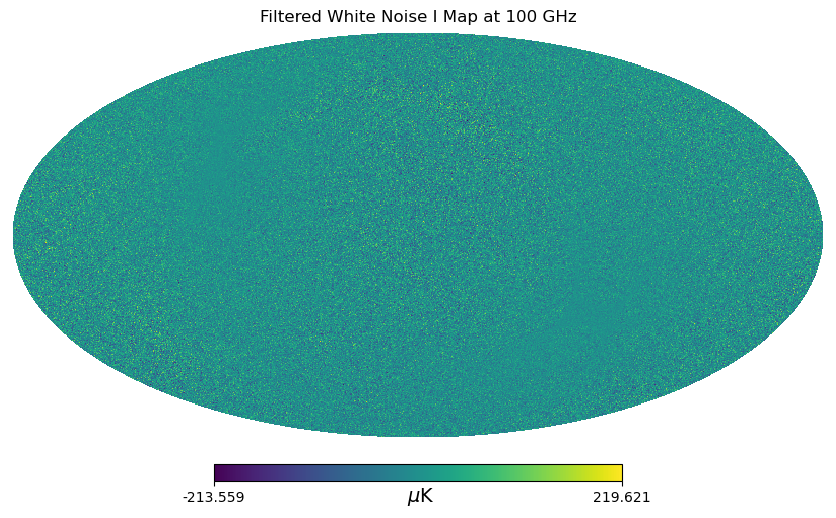

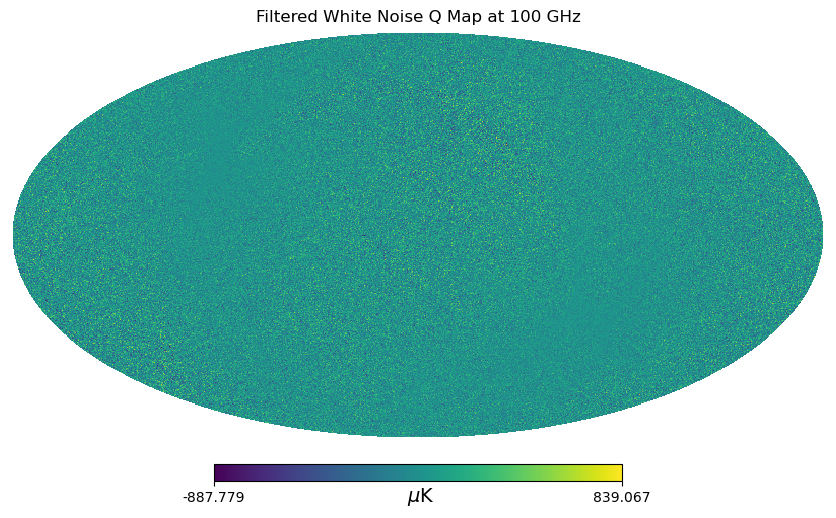

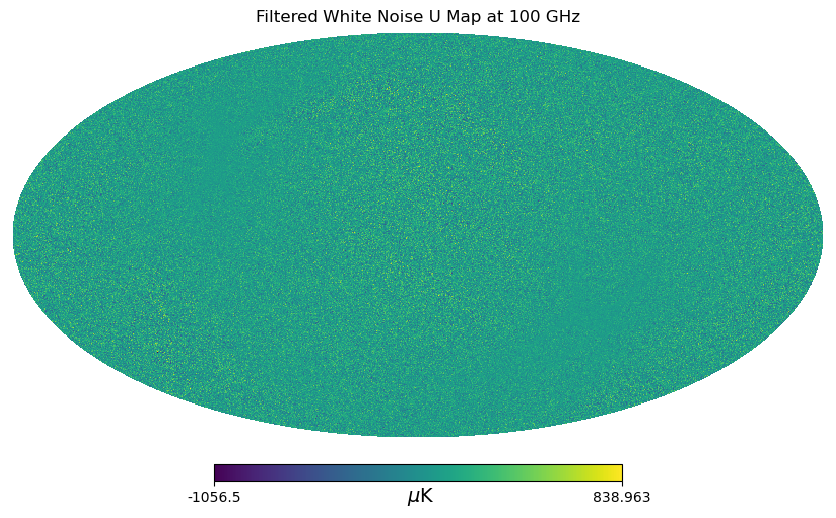

In [22]:
# Visualize the filtered white noise map
for i in fields:
    hp.mollview(white_noise_map_sim_filtered[fields.index(i)], title=f"Filtered White Noise {i} Map at 100 GHz", unit=" $\\mu$K")

In [ ]:
# Compare the power spectrum of the filtered white noise map with the Planck noise map
filterd_white_noise_map_sim_cl = hp.anafast(white_noise_map_sim_filtered, lmax=ellmax)


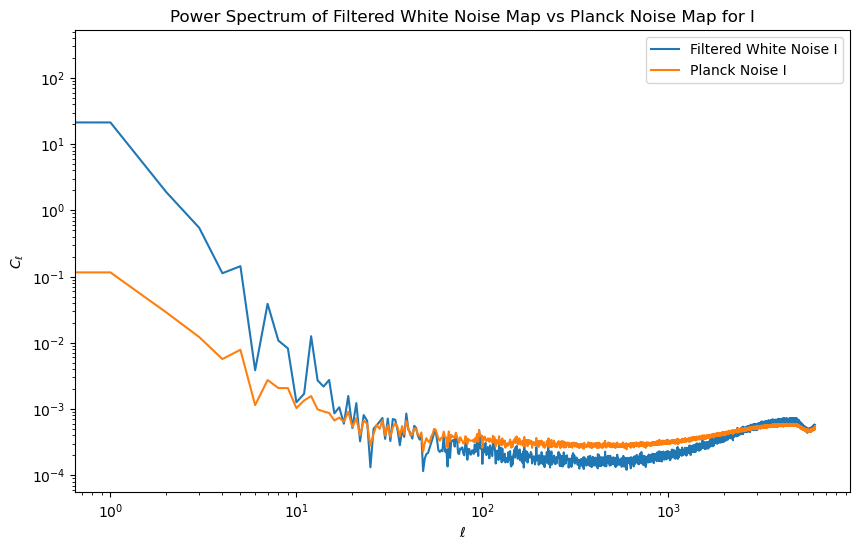

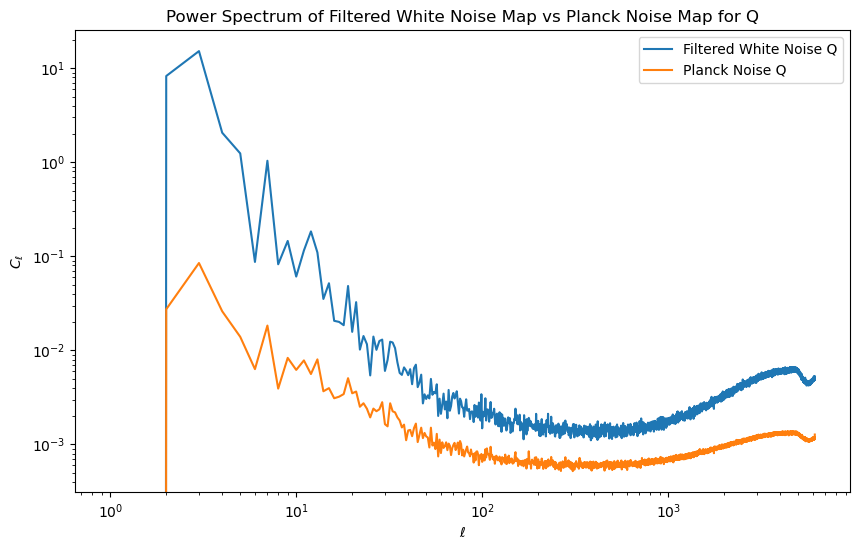

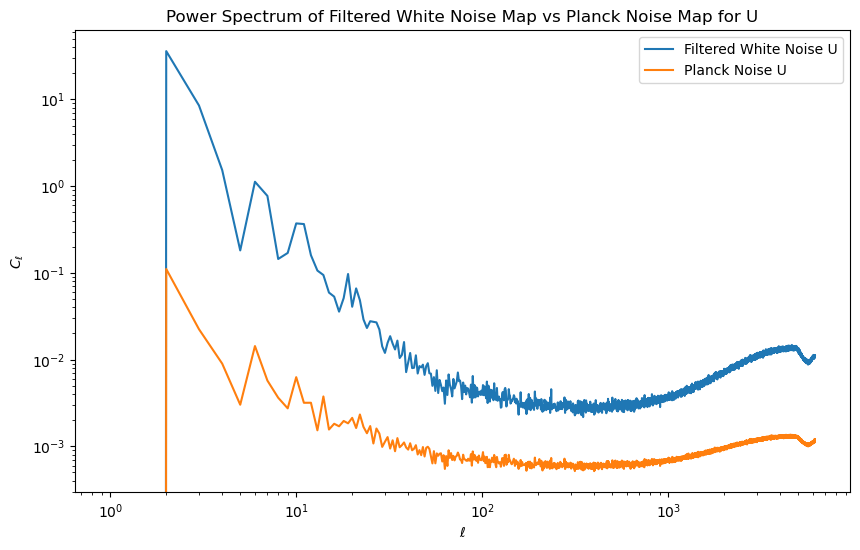

In [25]:
# Visualize the filtered white noise map
for i in range(3):
    plt.figure(figsize=(10, 6))
    plt.plot(filterd_white_noise_map_sim_cl[i], label=f"Filtered White Noise {fields[i]}")
    plt.plot(Planck_noise_map_cl[i], label=f"Planck Noise {fields[i]}")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("$\ell$")
    plt.ylabel("$C_{\ell}$")
    plt.legend()
    plt.title(f"Power Spectrum of Filtered White Noise Map vs Planck Noise Map for {fields[i]}")
    plt.show()